In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
#%matplotlib notebook

In [10]:
plt.rc('figure', figsize=(9,4))

In [30]:
def LoG_run(image, std=3, kernel_half_size=20, zero_range_LoG = 200, first_d_th=150 ):

    '''
    kernel_half_size : (default = 20)
        this is actually the half size of the filter.
        if you choose this value to be 20, then the filter will be (2*20+1, 2*20+1) = (41,41)
        
    zero_range_LoG : (default = 200)
        the LoG filter is actually the second derivative of the signal. The zeros of this function is 
        the locations that the first derivative is zero. This happens both the the peaks of the first
        derivative and also the segments that the first derivative is constant (the meat of the objects
        in the picture). This parameters gets ride of the intermediate values. if you choose this value
        to be for example 200, then all of the places that its second derivative is less than 200 will be
        considered as 0. and the values bigger that this number will be considered to be a very high value
    
    first_d_th : (default = 150)
        only those segments will be treated as edges (or IPs) that at those places the first derivative is 
        higher than a threshold. by doing this we reject counting the segments will constant intensity (that
        the have first dervative equal to zero)
        
        
    return : 
        this will be a matrix that is zero at the IPs (or equvalently the edges) and is 10000 any where else
    
    '''
    size=kernel_half_size
    kernel_x = np.array([1,0,-1])
    first_d = signal.convolve(image, kernel_x, mode='same')
    x = np.arange(-size,size+1)
    LoG_kernel = LoG(x, std=std)
    LoG_filtered = signal.convolve(image, LoG_kernel, mode='same')
    #LoG_filtered = np.abs(LoG_filtered)
    
    LoG_filtered[np.abs(LoG_filtered)<zero_range_LoG]=0
    LoG_filtered[np.abs(LoG_filtered)>zero_range_LoG]=10000

    filtered_ = LoG_filtered.copy()
    filtered_[(np.abs(first_d)<first_d_th)]=10000   # You can vary limit of the firs_d

    #fig, ax = plt.subplots(1)
    #ax.plot(filtered_/5)
    #ax.plot(image, alpha=0.1)
    
    return filtered_


In [160]:
def LoG(x, std):
    return (x**2/std**4 - 1/std**2) *np.exp(-(x**2) / (2*std**2))

def DoG(x, std):
    return (-x/std**2)*np.exp(-x**2/(2*std**2))

In [191]:
def MapTo(data, min_range=-1, max_range=1):
    min_ = data.min()
    max_ = data.max()
    return (data - min_)/(max_ - min_) *2 -1
    

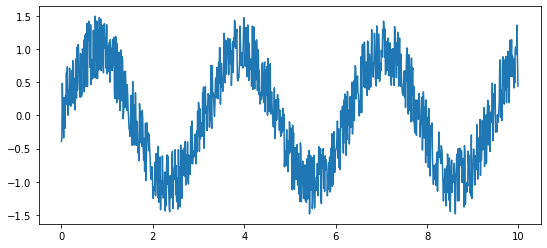

In [161]:
t = np.arange(0,10,0.01)
data = np.sin(2*t) + np.random.random(t.shape) - 0.5
plt.plot(t,data)

In [162]:
std=7
kernel_half_size=10
zero_range_LoG = 0.5
first_d_th=0
image = data.copy()

In [193]:
size=kernel_half_size
kernel_x = np.array([1,0,-1])
G_x = np.arange(-size, size+1)
DoG_kernel = DoG(x, std=12)
#first_d = signal.convolve(image_, kernel_x, mode='valid')
first_d = signal.convolve(image,DoG_kernel , mode='valid')
LoG_kernel = LoG(G_x, std=std)
LoG_filtered = signal.convolve(image, LoG_kernel, mode='valid')
#LoG_filtered = np.abs(LoG_filtered)

#LoG_filtered[np.abs(LoG_filtered)<zero_range_LoG]=0
#LoG_filtered[np.abs(LoG_filtered)>zero_range_LoG]=10000

#filtered_ = LoG_filtered.copy()
#filtered_[(np.abs(first_d)<first_d_th)]=10000   # You can vary limit of the firs_d

#fig, ax = plt.subplots(1)
#ax.plot(filtered_/5)
#ax.plot(image, alpha=0.1)

first_d = MapTo(first_d)
LoG_filtered = MapTo(LoG_filtered)

In [210]:
t = t[10:-10]

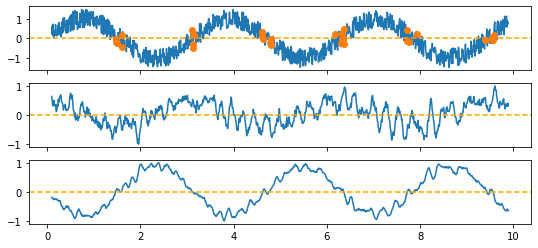

In [231]:
fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(t,data[10:-10])
ax[0].axhline(0,ls='--', c='orange')

ax[1].plot(t,first_d)
ax[1].axhline(0,ls='--', c='orange')

ax[2].plot(t,LoG_filtered)
ax[2].axhline(0,ls='--', c='orange')

criteria = (np.abs(LoG_filtered)<0.1) * (np.abs(first_d) > 0.4)

ax[0].plot(t[criteria],data[10:-10][criteria], 'o')


In [235]:
def derivative(signal):
    return signal[1:] - signal[:-1]

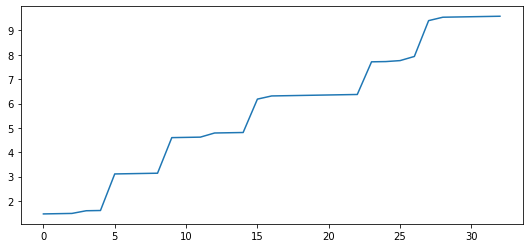

In [234]:
plt.plot(t[criteria])

In [237]:
der = derivative(t[criteria])

In [245]:
peak_loc = signal.find_peaks(der, height=0.5)[0]

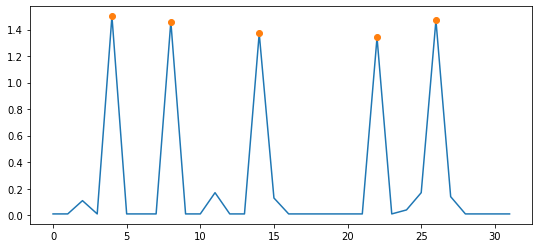

In [246]:
plt.plot(der)
plt.plot(peak_loc, der[peak_loc],'o')

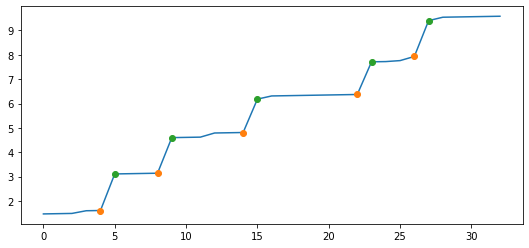

In [260]:
plt.plot(t[criteria])
plt.plot(peak_loc, t[criteria][peak_loc],'o')
plt.plot(peak_loc+1, t[criteria][peak_loc+1],'o')

In [268]:
t_ip = (t[criteria][peak_loc+1][:-1] + t[criteria][peak_loc][1:])/2
t_ip

array([3.125, 4.705, 6.275, 7.82 ])

/home/ali/anaconda3/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


ValueError: x and y must have same first dimension, but have shapes (4,) and (0, 980)

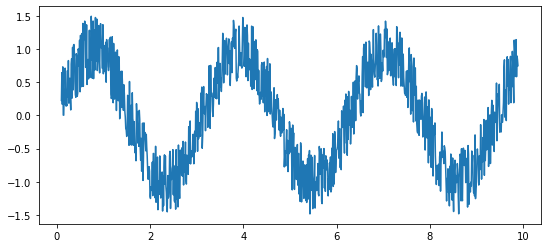

In [270]:
plt.plot(t,data[10:-10])
plt.plot(t_ip,data[10:-10][t==t_ip], 'o')
